# Group Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("Project_Data_export/train_competition_2026.csv")
train.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4,y_1,y_2
0,0,0,2068-09-19 23:34:11,1.38,49,7,1,3,1,0,1,105.5,95.0,67.4,36.6,23.2,33.4,107.4
1,0,0,2068-09-19 23:35:11,1.38,49,7,1,3,1,0,1,104.4,95.0,66.4,37.8,22.7,33.4,107.4
2,0,0,2068-09-19 23:36:11,1.38,49,7,1,3,1,0,1,104.0,95.0,65.2,37.0,22.1,33.4,107.4
3,0,0,2068-09-19 23:37:11,1.38,49,7,1,3,1,0,1,102.8,95.0,63.4,35.9,20.7,33.4,107.4
4,0,0,2068-09-19 23:38:11,1.38,49,7,1,3,1,0,1,101.3,95.1,59.1,34.5,18.1,33.4,107.4


In [3]:
test = pd.read_csv("Project_Data_export/test_no_outcome.csv")
test.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4
0,18,1,2134-04-01 22:23:14,-1.0,38,1,1,1,0,0,0,105.4,99.8,50.7,61.4,36.8
1,18,1,2134-04-01 22:24:14,-1.0,38,1,1,1,0,0,0,105.4,99.4,49.4,61.1,36.2
2,18,1,2134-04-01 22:25:14,-1.0,38,1,1,1,0,0,0,104.6,99.0,49.7,61.4,36.6
3,18,1,2134-04-01 22:26:14,-1.0,38,1,1,1,0,0,0,104.5,99.6,51.7,61.8,37.2
4,18,1,2134-04-01 22:27:14,-1.0,38,1,1,1,0,0,0,104.6,99.5,52.5,61.9,37.5


## EDA

Checking the number of rows and columns fro both train and test.


In [4]:
train.shape,test.shape

((432600, 18), (103500, 16))

Checking column types and missing counts so we can catch nulls or wrong types.


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432600 entries, 0 to 432599
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   obs     432600 non-null  int64  
 1   sub_id  432600 non-null  int64  
 2   time    432600 non-null  object 
 3   num_0   432600 non-null  float64
 4   num_1   432600 non-null  int64  
 5   num_2   432600 non-null  int64  
 6   cat_0   432600 non-null  int64  
 7   cat_1   432600 non-null  int64  
 8   cat_2   432600 non-null  int64  
 9   cat_3   432600 non-null  int64  
 10  cat_4   432600 non-null  int64  
 11  t_0     432600 non-null  float64
 12  t_1     432600 non-null  float64
 13  t_2     432600 non-null  float64
 14  t_3     432600 non-null  float64
 15  t_4     432600 non-null  float64
 16  y_1     432600 non-null  float64
 17  y_2     432600 non-null  float64
dtypes: float64(8), int64(9), object(1)
memory usage: 59.4+ MB


Counting unique observations in the `obs` column.


In [6]:
train['obs'].nunique()

14420

Counting how many unique subjects are in the data.


In [7]:
train['sub_id'].nunique()

1596

In [8]:
# Timepoints per observation window
train.groupby("obs")["time"].nunique().describe()

count    14420.0
mean        30.0
std          0.0
min         30.0
25%         30.0
50%         30.0
75%         30.0
max         30.0
Name: time, dtype: float64

- Every observation window contains exactly 30 timepoints
- This is a fixed-length time window, not variable-length
- So each obs is a short, uniform time series

In [9]:
train.groupby("sub_id")["obs"].nunique().describe()

count    1596.000000
mean        9.035088
std        10.876567
min         1.000000
25%         3.000000
50%         5.000000
75%        11.000000
max       117.000000
Name: obs, dtype: float64

- Each subject has multiple observation windows
- Most subjects have a small number of windows
- A few subjects have many repeated windows.

The dataset has a hierarchical structure in which each subject (sub_id) can have multiple observation windows (obs), and each observation window contains multiple time-stamped measurements. As a result, the data consists of repeated, time-indexed observations nested within observation windows, which are in turn nested within subjects.

Converting time to real datetime so time-based analysis works properly.


In [10]:
train["time"] = pd.to_datetime(train["time"])

Earliest and latest timestamps to see the time range.


In [11]:
print(f"Data spans from {train['time'].min()} to {train['time'].max()}")

Data spans from 2043-08-12 13:33:22 to 2151-08-06 15:13:59


The dataset spans approximately 108 years of timestamped data!

How long each subject appears, then summarizing the distribution.


In [12]:
train.groupby("sub_id")["time"].apply(lambda x: x.max() - x.min()).describe()

count                         1596
mean     1 days 06:34:40.488721804
std      1 days 15:28:15.364004196
min                0 days 00:29:00
25%                0 days 07:28:00
50%                0 days 16:41:00
75%                1 days 13:08:30
max               12 days 13:59:00
Name: time, dtype: object

It is the total calendar time between their first and last recorded measurement in the dataset, per subject across all windows.

Individual subjects are typically observed over short time spans, with a median duration of approximately 17 hours and a maximum of about 12.5 days. This suggests that absolute timestamps are less informative than relative time within observation windows for modeling. Although the dataset spans over a century in absolute calendar time, this reflects the aggregation of anonymized timestamps across subjects rather than meaningful long-term observation of any individual.

Summarizing the numeric features (mean, std, min/max, quartiles).


In [13]:
train[["num_0", "num_1", "num_2"]].describe()

,num_0,num_1,num_2
count,432600.000000,432600.000000,432600.000000
mean,-0.029135,32.900763,4.546047
std,0.970960,13.716405,3.613130
min,-2.940000,0.000000,0.000000
25%,-0.620000,24.000000,2.000000
50%,0.060000,31.000000,4.000000
75%,0.750000,42.000000,7.000000
max,1.500000,90.000000,19.000000


The numerical features show different distributions, with num_0 appearing approximately normalized and num_1 and num_2 behaving as discrete variables with varying ranges.

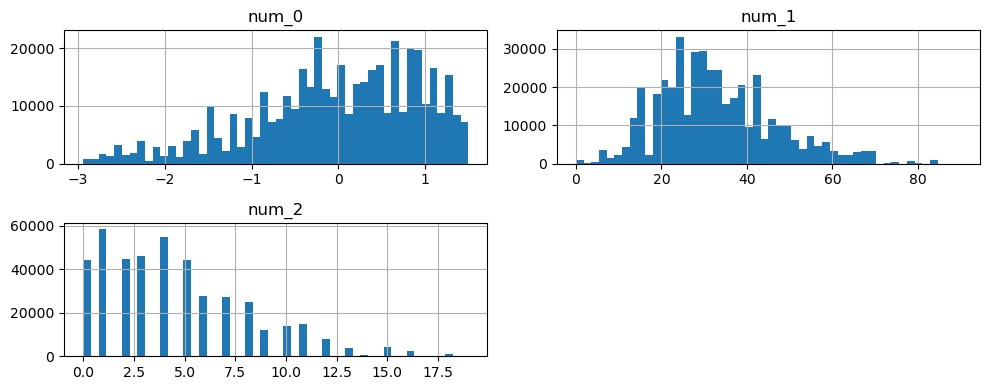

In [14]:
train[["num_0", "num_1", "num_2"]].hist(bins=50, figsize=(10,4))
plt.tight_layout()

The histogram of num_0 shows a roughly centered and continuous distribution, while num_1 is more spread out and right-skewed. num_2 consists of a small number of discrete integer values.

Outlier Check

<Axes: >

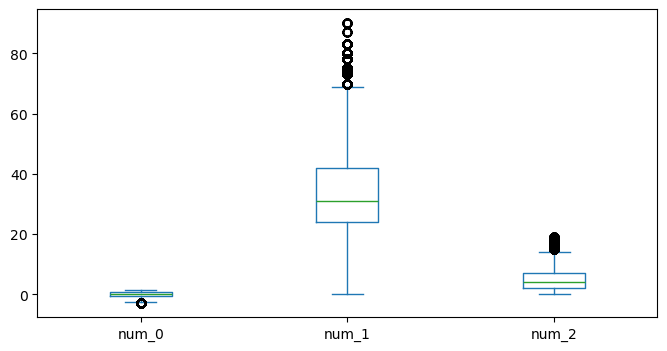

In [15]:
train[["num_0", "num_1", "num_2"]].plot.box(figsize=(8,4))

The above boxplots  reveal  outliers in num_1, with fewer extreme values in num_0 and num_2.

Relation with targets

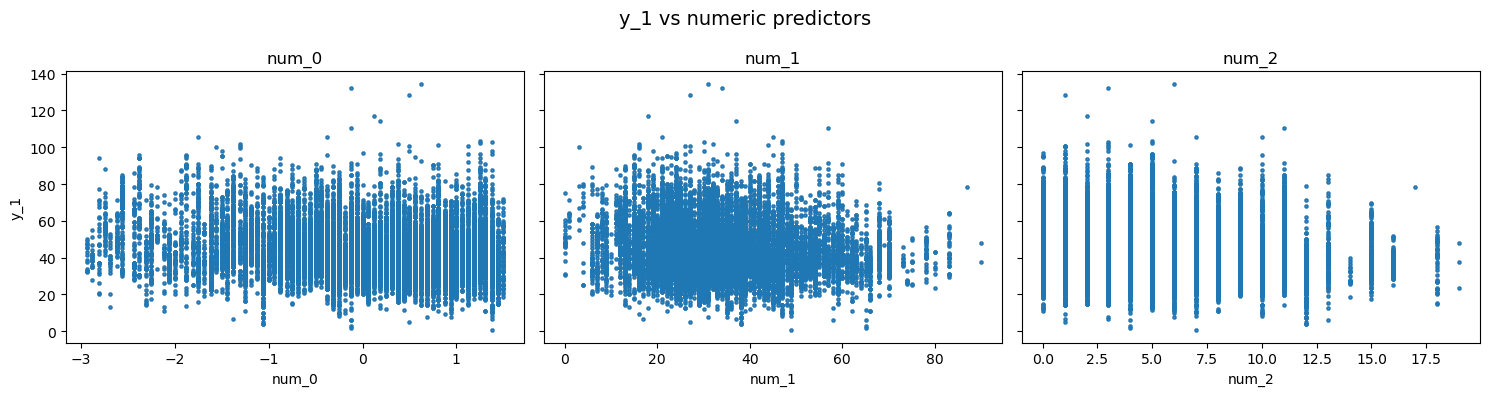

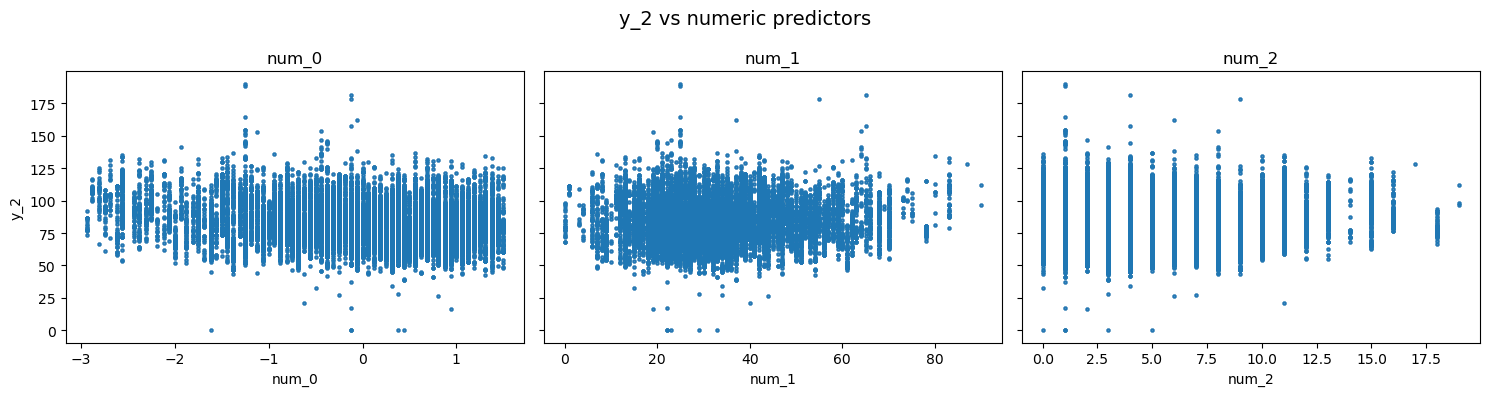

In [16]:
num_cols = ["num_0", "num_1", "num_2"]
targets = ["y_1", "y_2"]

for y in targets:
    fig, axes = plt.subplots(1, len(num_cols), figsize=(15, 4), sharey=True)
    
    for ax, x in zip(axes, num_cols):
        ax.scatter(train[x], train[y], alpha=0.05, s=5)
        ax.set_title(x)
        ax.set_xlabel(x)
    
    axes[0].set_ylabel(y)
    fig.suptitle(f"{y} vs numeric predictors", fontsize=14)
    plt.tight_layout()
    plt.show()

The scatter plots show that the numerical predictors do not exhibit strong linear relationships with either response variable.

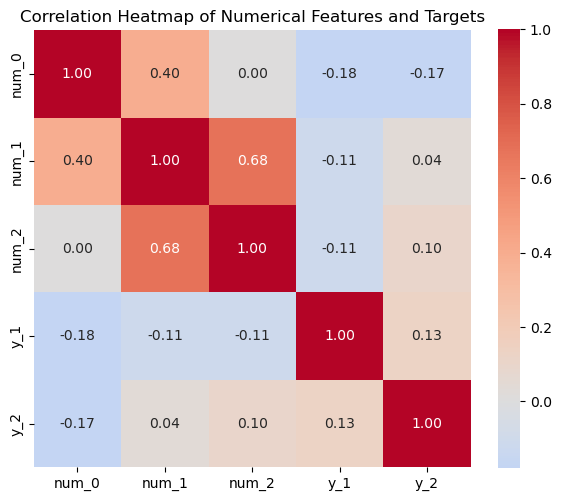

In [17]:
import seaborn as sns

corr = train[["num_0", "num_1", "num_2", "y_1", "y_2"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation Heatmap of Numerical Features and Targets")
plt.tight_layout()
plt.show()


- The heatmap shows moderate positive correlation between num_1 and num_2, indicating that these features may capture related information.
- All numerical predictors exhibit weak linear correlations with both response variables. So no single predictor has a strong linear relationship with the targets and that **non-linear patterns or interactions are likely more important.**

Categorical frequencies to see if any value dominates.


In [18]:
for c in [f"cat_{i}" for i in range(5)]:
    print(train[c].value_counts(normalize=True).head())

cat_0
0    0.568031
1    0.431969
Name: proportion, dtype: float64
cat_1
3    0.273093
2    0.257698
5    0.229473
1    0.146463
6    0.093273
Name: proportion, dtype: float64
cat_2
0    0.899931
1    0.100069
Name: proportion, dtype: float64
cat_3
0    0.781068
1    0.218932
Name: proportion, dtype: float64
cat_4
0    0.638558
1    0.361442
Name: proportion, dtype: float64


- The categorical variables show degrees of class imbalance. cat_0, cat_2, cat_3, and cat_4 are binary features with one dominant category, particularly cat_2, which is highly imbalanced with approximately 90% of observations in a single class!
- cat_1 contains multiple categories with a more distributed frequency pattern.

Averaging target values per category to see if categories relate to outcomes.


In [19]:
for c in [f"cat_{i}" for i in range(5)]:
    print(train.groupby(c)[["y_1", "y_2"]].mean())

             y_1        y_2
cat_0                      
0      43.874086  83.509452
1      45.329017  83.517052
             y_1        y_2
cat_1                      
1      43.619261  80.283911
2      39.811593  82.509666
3      45.785983  84.968870
5      47.932312  84.852653
6      46.654357  83.794245
             y_1        y_2
cat_2                      
0      44.619804  83.116874
1      43.448295  87.072744
             y_1        y_2
cat_3                      
0      44.512371  83.426704
1      44.467615  83.819661
             y_1        y_2
cat_4                      
0      44.534903  83.193481
1      44.445453  84.076759


Most categorical features show only minor differences in average target values across categories. However, cat_1 exhibits larger variation, maybe potential relevance for predicting the response variables?

In [20]:
train.groupby("obs")[["t_0","t_1","t_2","t_3","t_4"]].nunique().head()

,t_0,t_1,t_2,t_3,t_4
obs,,,,,
0,27,11,29,26,26
1,27,20,28,23,26
2,27,26,25,26,27
3,18,22,28,20,22
4,21,18,27,23,22


In [21]:
one_obs = train["obs"].iloc[0]
one_obs


np.int64(0)

In [22]:
sample = train[train["obs"] == one_obs].sort_values("time")

sample[["time", "t_0", "t_1", "t_2", "t_3", "t_4"]].head(10)


,time,t_0,t_1,t_2,t_3,t_4
0,2068-09-19 23:34:11,105.5,95.0,67.4,36.6,23.2
1,2068-09-19 23:35:11,104.4,95.0,66.4,37.8,22.7
2,2068-09-19 23:36:11,104.0,95.0,65.2,37.0,22.1
3,2068-09-19 23:37:11,102.8,95.0,63.4,35.9,20.7
4,2068-09-19 23:38:11,101.3,95.1,59.1,34.5,18.1
5,2068-09-19 23:39:11,99.7,94.8,56.8,33.4,16.5
6,2068-09-19 23:40:11,101.2,94.7,60.8,35.4,19.5
7,2068-09-19 23:41:11,99.9,94.2,64.3,36.2,20.7
8,2068-09-19 23:42:11,107.2,94.8,67.7,38.3,24.2
9,2068-09-19 23:43:11,109.0,95.4,68.0,35.5,22.9


The variables t_0–t_4 change across consecutive timestamps within the same obs window. This shows that they are time dependent measurements recorded at each timepoint.

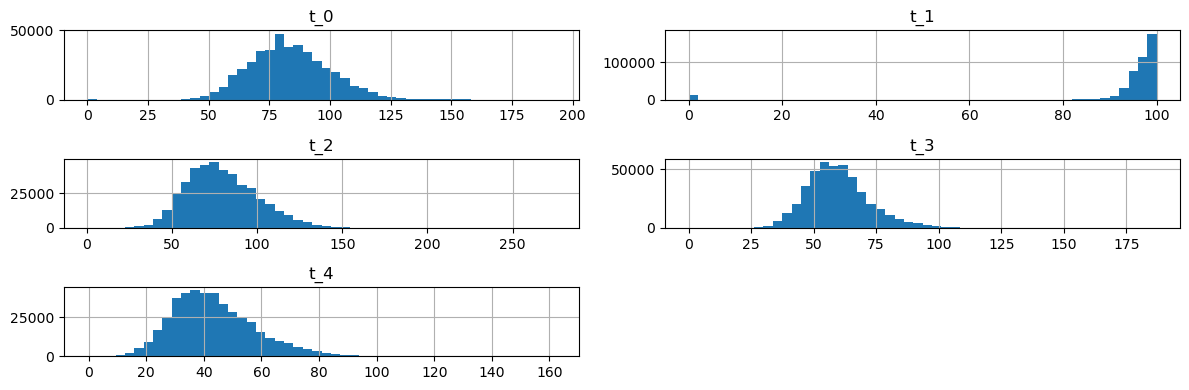

In [23]:
train[[f"t_{i}" for i in range(5)]].hist(bins=50, figsize=(12,4))
plt.tight_layout()

Most values are concentrated around their typical levels but some features show skewed distributions with a few extreme values. 

Checking the correlation matrix 

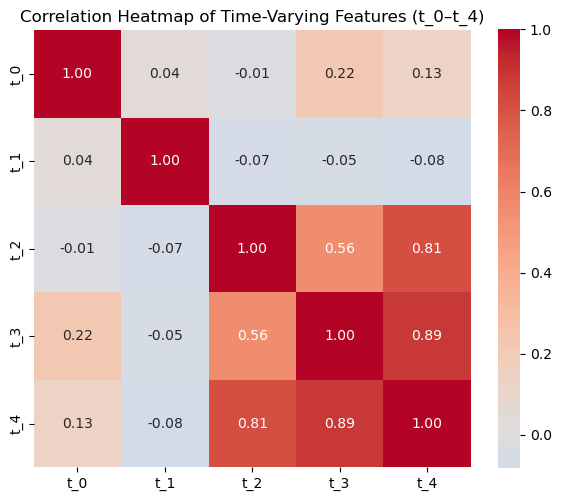

In [24]:
t_cols = [f"t_{i}" for i in range(5)]

corr_t = train[t_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_t,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation Heatmap of Time-Varying Features (t_0–t_4)")
plt.tight_layout()
plt.show()


The  features are not all independent: t_2, t_3, and t_4 are highly correlated, while t_0 and t_1 are mostly weakly related to the rest. This suggests that some time varying signals move together over time

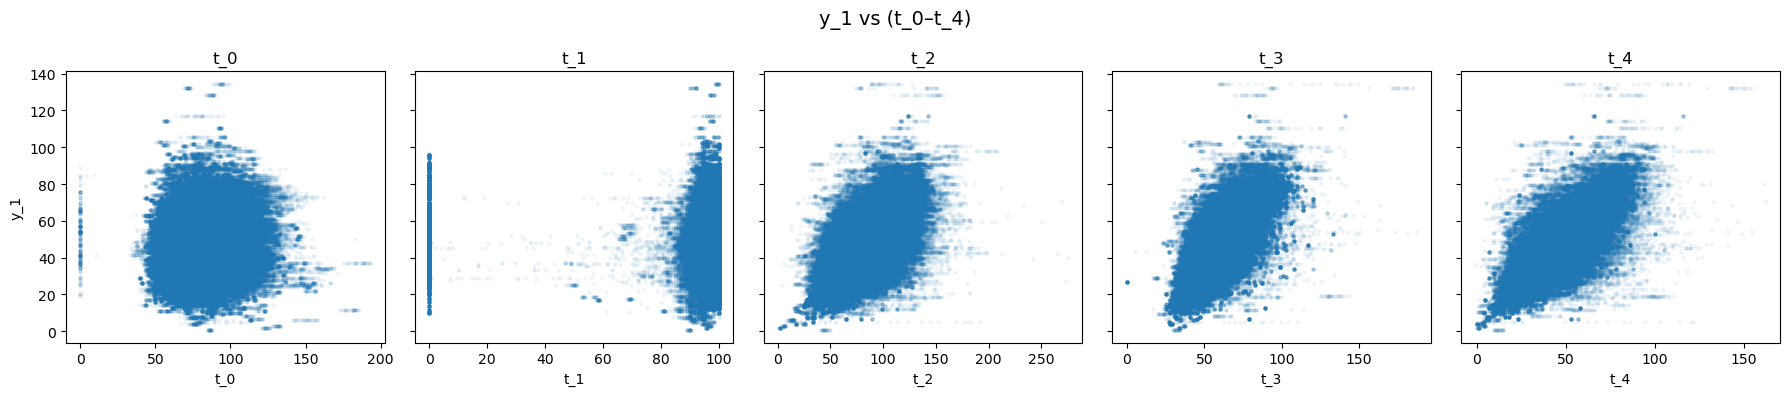

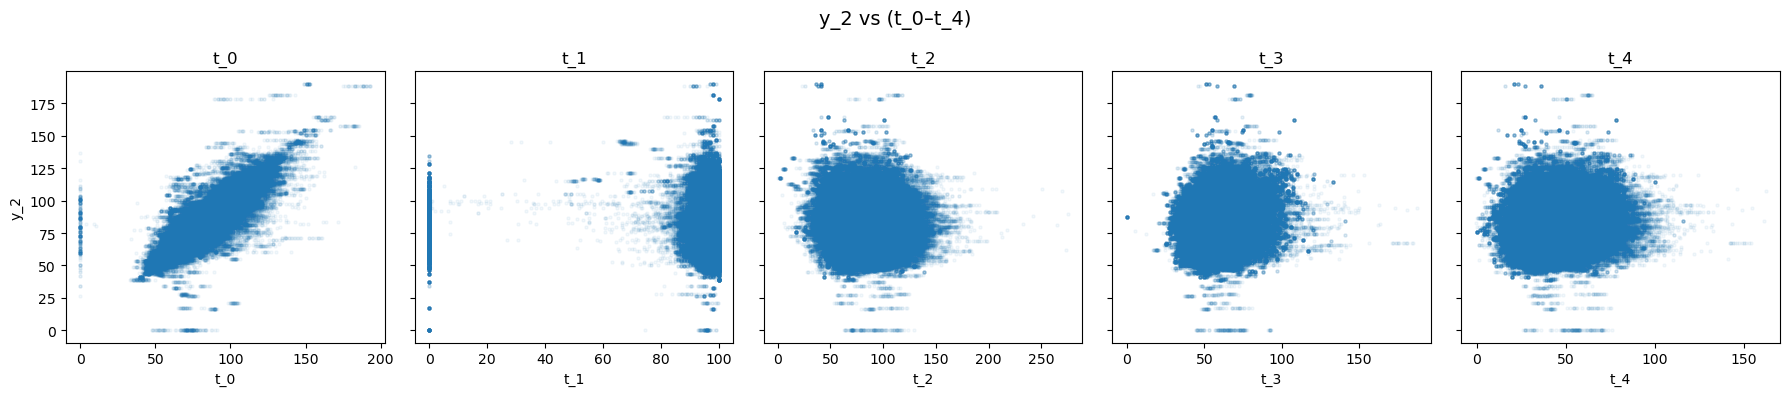

In [25]:
for y in ["y_1", "y_2"]:
    fig, axes = plt.subplots(1, len(t_cols), figsize=(18, 4), sharey=True)

    for ax, t in zip(axes, t_cols):
        ax.scatter(train[t], train[y], alpha=0.05, s=5)
        ax.set_title(t)
        ax.set_xlabel(t)

    axes[0].set_ylabel(y)
    fig.suptitle(f"{y} vs (t_0–t_4)", fontsize=14)
    plt.tight_layout()
    plt.show()


Several signals exhibit structured relationships with the targets!
In particular, t_2, t_3, and t_4 show positive associations with y_1, while t_0 is more strongly related to y_2.

The relationships are noisy and non-linear rather than strictly linear. Simple linear models maybe difficult to capture these patterns!

Extracting minute and second from the timestamp as possible features to use in model.


In [26]:
train["minute"] = train["time"].dt.minute
train["second"] = train["time"].dt.second
train = train.drop(columns=["time"])

## TRAINING

In [27]:
X = train.drop(columns=["obs", "sub_id", "y_1", "y_2"])

Applying a group based split using sub_id to avoid sub_id data leakage.

In [28]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(train, groups=train["sub_id"]))

train_df = train.iloc[train_idx]
val_df   = train.iloc[val_idx]


In [29]:
X_train = train_df.drop(columns=["obs", "sub_id", "y_1", "y_2"])
y_train = train_df[["y_1", "y_2"]]

X_val = val_df.drop(columns=["obs", "sub_id", "y_1", "y_2"])
y_val = val_df[["y_1", "y_2"]]


## Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])

avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae



(6.873145412563668, 5.129144118430485, 6.001144765497076)

MAE = Mean Absolute Error -> On average how far off is the model from the true value **|true − predicted|**


- For y_1:

On average the model’s prediction for y_1 is about 6.8 units away from the true value.

- For y_2:

On average the model’s prediction for y_2 is about 5.1 units away from the true value.

- Overall:

Across both targets the model is typically off by about 6 units.

---

In [31]:
test = pd.read_csv("Project_Data_export/test_no_outcome.csv")

test["time"] = pd.to_datetime(test["time"])
test["minute"] = test["time"].dt.minute
test["second"] = test["time"].dt.second
test = test.drop(columns=["time"])

X_test = test.drop(columns=["obs", "sub_id"])
X_test = X_test[X_train.columns]

test_preds = model.predict(X_test)

submission = pd.DataFrame({
    "obs": test["obs"],
    "y_1": test_preds[:, 0],
    "y_2": test_preds[:, 1]
})
submission = (
    submission
    .groupby("obs", as_index=False)
    .mean()
)
submission.to_csv("sample_submission.csv", index=False)
submission.head()


,obs,y_1,y_2
0,18,41.233010,104.322923
1,19,35.658113,99.847577
2,20,36.426780,96.890190
3,21,37.353413,97.284880
4,22,37.983003,96.457007


In [32]:
submission["obs"].is_unique


True

## Linear regression

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])
avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae


(6.275285776029188, 4.661493993253021, 5.4683898846411045)

---

## Ridge regression

In [34]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0, random_state=42)

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])
avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae


(6.275285585298678, 4.661492397455618, 5.468388991377148)

## Lasso regression

In [35]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.01, random_state=42)

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

# Lasso outputs shape (n_samples,) if y is single target
# so make sure y_train is 2D
val_preds = val_preds.reshape(-1, 2)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])
avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae


(6.273999701093587, 4.653360701923564, 5.463680201508575)

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
)

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])
avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae


(6.230543992100876, 4.525052437866622, 5.377798214983748)

## ExtraTress Regressor

In [37]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])
avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae


(6.867779469722695, 5.21201134974533, 6.0398954097340125)

## Trying without the groupshuffle

In [38]:
from sklearn.model_selection import train_test_split

# split rows randomly (this allows the same sub_id in train & val)
train_df, val_df = train_test_split(
    train,
    test_size=0.2,
    random_state=42
)

X_train = train_df.drop(columns=["obs", "sub_id", "y_1", "y_2"])
y_train = train_df[["y_1", "y_2"]]

X_val = val_df.drop(columns=["obs", "sub_id", "y_1", "y_2"])
y_val = val_df[["y_1", "y_2"]]


In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
val_preds = model.predict(X_val)

mae_y1 = mean_absolute_error(y_val["y_1"], val_preds[:, 0])
mae_y2 = mean_absolute_error(y_val["y_2"], val_preds[:, 1])
avg_mae = (mae_y1 + mae_y2) / 2

mae_y1, mae_y2, avg_mae


(2.8208203308868858, 2.164568882714981, 2.4926946068009332)

---